# N-MNIST Classification

In this tutorial, we propose to train a network using per-layer local losses, as describe in [Kaiser et al. '20].
This tutorial is based on the SLAYER N-MNIST tutorial and we refer to it for data preprocessing.

NMNIST dataset is freely available [here](https://www.garrickorchard.com/datasets/n-mnist) (© CC-4.0).

> Orchard, G.; Cohen, G.; Jayawant, A.; and Thakor, N. _"Converting Static Image Datasets to Spiking Neuromorphic Datasets Using Saccades"_,
Frontiers in Neuroscience, vol.9, no.437, Oct. 2015


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

import lava.lib.dl.decolle as decolle
import lava.lib.dl.slayer as slayer

# Create Dataset

The dataset class follows standard torch dataset definition. They are defined in `nmnist.py`. We will just import the dataset and augmentation routine here.

In [2]:
from tutorials.lava.lib.dl.slayer.nmnist.nmnist import NMNISTDataset, augment

# Create Network

The network definition is done in PyTorch using a `torch.nn.Module`.

We consider here a network of Dense cuba blocks as shown below.
In addition to spiking blocks, DECOLLE models use fixed, readout layers to obtain per-layer errors.
The behavior of the cuba blocks is broken down during the forward pass to obtain the voltage, which is used in the custom `DECOLLELoss`.

As DECOLLE is typically trained online (i.e., updating weights at every time-step), the state of the neurons is set to be persistent, and reset at the beginning of every batch of examples.
Furthermore, the network goes through a burn-in period at every batch of examples to initialize its state before applying updates.

In [3]:
class DECOLLENetwork(torch.nn.Module):
    def __init__(self, input_shape, hidden_shape, output_shape, burn_in=0):

        super(DECOLLENetwork, self).__init__()

        neuron_params = {
            'threshold': 1.25,
            'current_decay': 0.25,
            'voltage_decay': 0.03,
            'tau_grad': 0.03,
            'scale_grad': 3.,
            'requires_grad': True,
            'persistent_state': True
        }
        neuron_params_drop = {**neuron_params}

        self.burn_in = burn_in
        self.blocks = torch.nn.ModuleList()
        self.readout_layers = torch.nn.ModuleList()

        hidden_shape = [input_shape] + hidden_shape
        for i in range(len(hidden_shape)-1):
            self.blocks.append(slayer.block.cuba.Dense(
                neuron_params_drop, hidden_shape[i], hidden_shape[i+1],
                weight_norm=False)
            )

            # One fixed readout per layer
            readout = torch.nn.Linear(hidden_shape[i+1],
                                      output_shape,
                                      bias=False)
            readout.weight.requires_grad = False
            self.readout_layers.append(readout)


    def forward(self, spike):
        spike.requires_grad_()
        spikes = []
        readouts = []
        voltages = []
        count = []

        for block in self.blocks:
            # Decompose the behavior of the block to obtain the voltage
            # for the regularization
            z = block.synapse(spike.detach())
            _, voltage = block.neuron.dynamics(z)
            voltages.append(voltage)

            spike = block.neuron.spike(voltage)
            spikes.append(spike)
            count.append(torch.mean(spike.detach()))

        for ro, spike in zip(self.readout_layers, spikes):
            # Compute readouts
            readout = []
            for t in range(spike.shape[-1]):
                readout.append(ro(spike[..., t]))
            readouts.append(torch.stack(readout, dim=-1))

        return spikes, readouts, voltages, count

    def init_state(self, inputs, burn_in=None):
        self.reset_()
        # initialize network state + crop inputs
        if burn_in is None:
            burn_in = self.burn_in

        self.forward(inputs[..., :burn_in])
        return inputs[..., burn_in:]

    def reset_(self):
        # reset the state after each example
        for block in self.blocks:
            block.neuron.current_state[:] = 0.
            block.neuron.voltage_state[:] = 0.

# Instantiate Network, Optimizer, DataSet and DataLoader

In [4]:
trained_folder = 'Trained'
os.makedirs(trained_folder, exist_ok=True)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

net = DECOLLENetwork(input_shape=34 * 34 * 2,
                     hidden_shape=[512, 256],
                     output_shape=10,
                     burn_in=10).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

training_set = NMNISTDataset(train=True,
                             transform=augment, download=True)
testing_set  = NMNISTDataset(train=False,
                             )

train_loader = DataLoader(dataset=training_set, batch_size=32, shuffle=True)
test_loader  = DataLoader(dataset=testing_set , batch_size=32, shuffle=True)


NMNIST dataset is freely available here:
https://www.garrickorchard.com/datasets/n-mnist

(c) Creative Commons:
    Orchard, G.; Cohen, G.; Jayawant, A.; and Thakor, N.
    "Converting Static Image Datasets to Spiking Neuromorphic Datasets Using
    Saccades",
    Frontiers in Neuroscience, vol.9, no.437, Oct. 2015



# Error module

Training with decolle utilizes the custom loss `slayer.loss.DECOLLELoss`
In DECOLLELoss, one must define an error function (typically, a Pytorch loss such as `torch.nn.CrossEntropyLoss`) used to compute per-layer pseudo-errors.
The regularization allows to control per-layer spike rates.

In [5]:
error = decolle.loss.DECOLLELoss(torch.nn.CrossEntropyLoss, reg=0.01, reduction='mean')

# Stats and Assistants

Users can benefit from slayer's `slayer.utils.LearningStats` statistics logger for training, validation and testing, in addition with the custom `slayer.utils.DECOLLEAssistant` module which wraps common training validation and testing routines. We do not use this module in this notebook, to break down training with DECOLLE. Please refer to `nmist_decolle.py` for an example.

# Training Loop

Training can be done by updating the weights as every time step, as in the original work, or at the end of every batch of data as in slayer. We illustrate both below.
When using the `DECOLLEAssistant`, all of the training and recording is done under the hood.

In [6]:
epochs = 5
training_mode = 'batch' # either 'online' or 'batch'

test_losses = []
test_accs_l1 = [] # test accs of the first layer
test_accs_l2 = [] # test accs of the second layer

for epoch in range(epochs):
    train_iter = iter(train_loader)
    net.train()
    for inputs, target in train_iter: # training loop
        inputs = inputs.reshape([inputs.shape[0],
                                 -1,
                                 inputs.shape[-1]]).to(device)
        target = target.to(device)

        # Reset net state + burn-in + resize the inputs accordingly
        inputs = net.init_state(inputs)

        # training phase
        if training_mode == 'online':
            for t in range(inputs.shape[-1]):
                x = inputs[..., t].unsqueeze(-1)
                spikes, readouts, voltages, count_t = net(x)
                loss = error(readouts, voltages, target)
                loss.backward()

                optimizer.step()
                optimizer.zero_grad()
        else:
            spikes, readouts, voltages, count = net(inputs)
            loss = error(readouts, voltages, target)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()


    with torch.no_grad():
        test_iter = iter(test_loader)
        net.eval()
        preds_test_l1 = torch.Tensor()
        preds_test_l2 = torch.Tensor()
        targets_test = torch.Tensor()
        test_losses.append(0.)
        for inputs, target in test_iter: # test loop
            with torch.no_grad():
                inputs = inputs.reshape([inputs.shape[0],
                                         -1,
                                         inputs.shape[-1]]).to(device)
                target = target.to(device)

                # Reset net state + burn-in + resize the inputs accordingly
                inputs = net.init_state(inputs)

                # forward pass + record loss
                spikes, readouts, voltages, count = net(inputs)
                loss = error(readouts, voltages, target)
                test_losses[epoch] += loss.cpu().numpy()

                preds_test_l1 = torch.cat((preds_test_l1, torch.mean(readouts[0], dim=-1).argmax(-1).cpu()))
                preds_test_l2 = torch.cat((preds_test_l2, torch.mean(readouts[1], dim=-1).argmax(-1).cpu()))
                targets_test = torch.cat((targets_test, target.cpu()))

        acc_test_l1 = torch.mean((preds_test_l1 == targets_test).type(torch.float))
        acc_test_l2 = torch.mean((preds_test_l2 == targets_test).type(torch.float))

        test_accs_l1.append(acc_test_l1.cpu().numpy())
        test_accs_l2.append(acc_test_l2.cpu().numpy())

    if (epoch+1) % 1 == 0:
        print('\r', ' '*len(f'\r[Epoch {epoch:2d}/{epochs}]'))
        print("Test  loss = %f (min = %f)    accuracy = %f (max = %f)" % (test_losses[epoch],
                                                                          np.min(test_losses),
                                                                          acc_test_l2,
                                                                          np.max(test_accs_l2)))

    if acc_test_l2 >= np.max(test_accs_l2):
        torch.save(net.state_dict(), trained_folder + '/network.pt')

              
Test  loss = 912.369222 (min = 912.369222)    accuracy = 0.818100 (max = 0.818100)
              
Test  loss = 895.828446 (min = 895.828446)    accuracy = 0.876200 (max = 0.876200)
              
Test  loss = 894.431683 (min = 894.431683)    accuracy = 0.879700 (max = 0.879700)
              
Test  loss = 888.569051 (min = 888.569051)    accuracy = 0.885900 (max = 0.885900)
              
Test  loss = 891.014585 (min = 888.569051)    accuracy = 0.881000 (max = 0.885900)


# Plot the learning curves

Plotting the learning curves is as easy as calling `stats.plot()`.

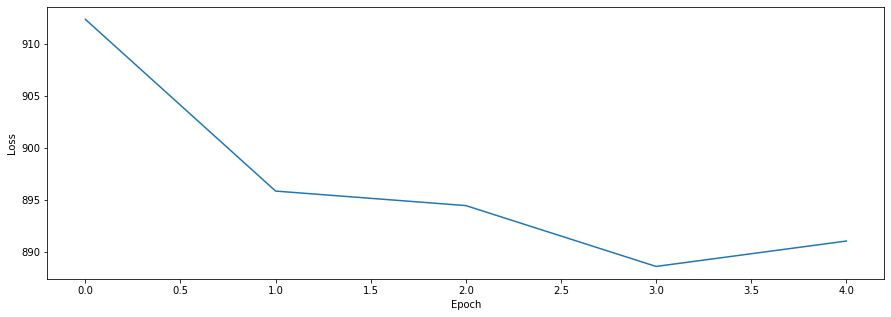

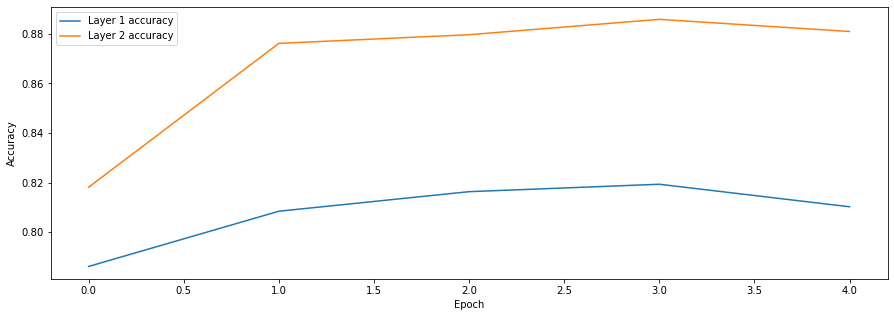

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.figure(figsize=(15, 5))
plt.plot(test_accs_l1, label='Layer 1 accuracy')
plt.plot(test_accs_l2, label='Layer 2 accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()